# **_LABORATORIO 18_**

In [19]:
#Importando las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import model_evaluation_utils as meu

from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, auc, roc_curve
from sklearn.preprocessing import label_binarize
from mlxtend.plotting import plot_decision_regions

#Just in Case
import warnings
warnings.filterwarnings('ignore')

import h2o
from h2o.estimators import H2ORandomForestEstimator

In [2]:
os.chdir('D:\Social Data Consulting\Python for Data Science\data')

In [4]:
miArchivo="bank-full.csv"
df_bank=pd.read_csv(miArchivo,sep=';')
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df_bank.shape

(45211, 17)

In [7]:
columnas=df_bank.columns.to_list()
columnas

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [8]:
predictores=columnas[0:len(columnas)-1]
target=columnas[len(columnas)-1]
print(predictores)
print(target)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
y


### **_1. Dividir la data en 70% de entrenamiento y lo restante para la data de testeo._**

In [16]:
X=df_bank.iloc[:,0:df_bank.shape[1]-1].values
y=df_bank.iloc[:,df_bank.shape[1]-1].values

In [18]:
xtrain,xtest,ytrain,ytest=train_test_split(X,
                                           y,
                                          test_size=0.3,
                                          stratify=y,
                                          random_state=2020)

In [29]:
df_xtrain=pd.DataFrame(xtrain,columns=predictores)
df_ytrain=pd.DataFrame(ytrain,columns=['y'])

df_xtest=pd.DataFrame(xtest,columns=predictores)
df_ytest=pd.DataFrame(ytest,columns=['y'])

df_train=pd.concat([df_xtrain,df_ytrain],axis=1)
df_test=pd.concat([df_xtest,df_ytest],axis=1)

### **_2. Entrenar el modelo con los siguientes parametros 60 arboles,3 de profundidad y 8 folders para la validacion cruzada._**

In [33]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 min 08 secs
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,4 months and 1 day !!!
H2O_cluster_name:,H2O_from_python_Diego_LeÃ³n_lu5goh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.973 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [34]:
datah20_train=h2o.H2OFrame(df_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
#Instanciamos un objeto de clase H2ORandomForestEstimator
m=h2o.estimators.H2ORandomForestEstimator(nfolds=8, #particiones para CV
                                          max_depth=3, #maxima profundidad
                                          ntrees=60, #número de arboles
                                          seed=2020) #semilla

In [36]:
#Hacer que el modelo aprenda de los datos
m.train(x=predictores,
       y=target,
       training_frame=datah20_train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


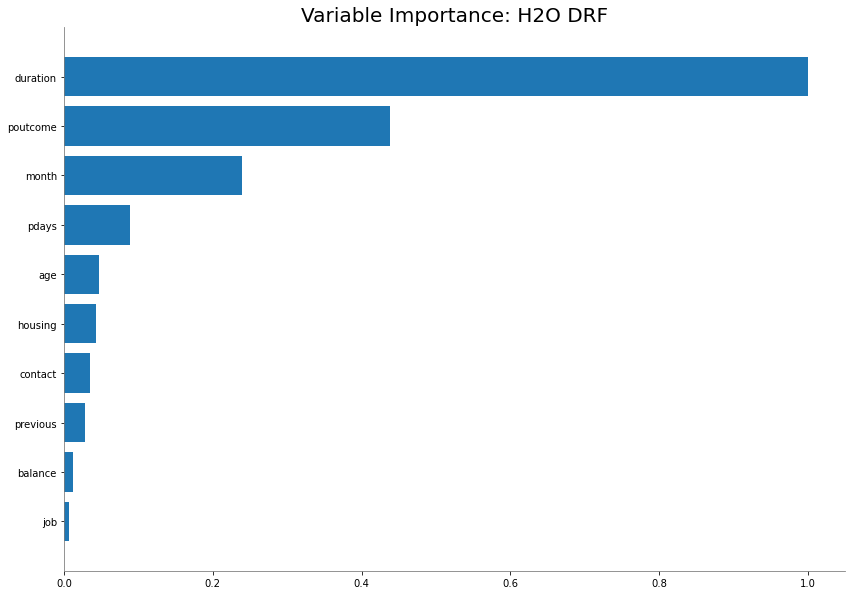

In [37]:
#Identificando a las variables más importantes para Random Forest
m.varimp_plot()

### **_3. Encontrar el AUC del modelo de la validacion cruzada para los datos de entrenamiento._**

In [38]:
#Evaluar la performance del modelo con los datos de entrenamiento
performance_train= m.model_performance(datah20_train)
performance_train


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.07684753744374091
RMSE: 0.2772138839303344
LogLoss: 0.26268415169621
Mean Per-Class Error: 0.17503263095226695
AUC: 0.9002002080377263
AUCPR: 0.5599317373296461
Gini: 0.8004004160754525

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1505349286292729: 


,,no,yes,Error,Rate
0,no,24634.0,3311.0,0.1185,(3311.0/27945.0)
1,yes,979.0,2723.0,0.2645,(979.0/3702.0)
2,Total,25613.0,6034.0,0.1356,(4290.0/31647.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.150535,0.559367,245.0
1,max f2,0.107847,0.666531,276.0
2,max f0point5,0.336490,0.561638,120.0
3,max accuracy,0.336490,0.902392,120.0
4,max precision,0.618973,1.000000,0.0
5,max recall,0.046329,1.000000,394.0
6,max specificity,0.618973,1.000000,0.0
7,max absolute_mcc,0.147361,0.505410,247.0
8,max min_per_class_accuracy,0.099409,0.819827,285.0
9,max mean_per_class_accuracy,0.084928,0.824967,305.0



Gains/Lift Table: Avg response rate: 11.70 %, avg score: 11.70 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010017,0.492044,6.984521,6.984521,0.817035,0.541393,0.817035,0.541393,0.069962,0.069962,598.452111,598.452111,0.067887
1,2,0.020002,0.433412,6.411467,6.698447,0.750000,0.459361,0.783570,0.500442,0.064019,0.133982,541.146677,569.844659,0.129079
2,3,0.030019,0.385826,5.582223,6.325981,0.652997,0.409420,0.740000,0.470069,0.055916,0.189897,458.222344,532.598055,0.181059
3,4,0.040004,0.366046,5.167047,6.036705,0.604430,0.375325,0.706161,0.446421,0.051594,0.241491,416.704706,503.670489,0.228179
4,5,0.050021,0.351212,4.503533,5.729683,0.526814,0.358645,0.670246,0.428843,0.045111,0.286602,350.353292,472.968309,0.267922
5,6,0.100009,0.303804,4.031146,4.880683,0.471555,0.327336,0.570932,0.378106,0.201513,0.488115,303.114557,388.068266,0.439519
6,7,0.149998,0.246676,2.593767,4.118538,0.303413,0.279035,0.481778,0.345089,0.129660,0.617774,159.376658,311.853789,0.529744
7,8,0.200019,0.136685,2.705534,3.765175,0.316488,0.193084,0.440442,0.307076,0.135332,0.753106,170.553367,276.517522,0.626357
8,9,0.300250,0.088152,1.196592,2.907719,0.139975,0.103097,0.340139,0.238983,0.119935,0.873042,19.659153,190.771916,0.648672
9,10,0.400006,0.077722,0.617385,2.336538,0.072220,0.081926,0.273323,0.199815,0.061588,0.934630,-38.261454,133.653791,0.605448


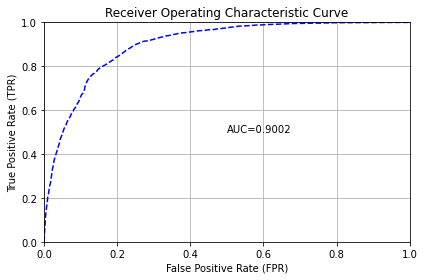

In [39]:
#Podemos obtener la curva ROC y AUC para los Datos de Entrenamiento
performance_train.plot('roc')

### **_4. Obtener el AUC del modelo con la data de testeo._**

In [40]:
datah20_test=h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [41]:
#Evaluar la performance del modelo con los datos de entrenamiento
performance_test= m.model_performance(datah20_test)
performance_test


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.07688627247876095
RMSE: 0.2772837400187053
LogLoss: 0.26243678330722836
Mean Per-Class Error: 0.17040776905999044
AUC: 0.9027133185696866
AUCPR: 0.5620574210835447
Gini: 0.8054266371393732

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1502812096405597: 


,,no,yes,Error,Rate
0,no,10610.0,1367.0,0.1141,(1367.0/11977.0)
1,yes,424.0,1163.0,0.2672,(424.0/1587.0)
2,Total,11034.0,2530.0,0.132,(1791.0/13564.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.150281,0.564974,237.0
1,max f2,0.094045,0.670413,287.0
2,max f0point5,0.327491,0.558024,116.0
3,max accuracy,0.347943,0.902094,99.0
4,max precision,0.606198,1.000000,0.0
5,max recall,0.051137,1.000000,382.0
6,max specificity,0.606198,1.000000,0.0
7,max absolute_mcc,0.150281,0.510519,237.0
8,max min_per_class_accuracy,0.097318,0.820656,283.0
9,max mean_per_class_accuracy,0.083994,0.829592,304.0



Gains/Lift Table: Avg response rate: 11.70 %, avg score: 11.57 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010027,0.477801,6.975815,6.975815,0.816176,0.530204,0.816176,0.530204,0.069943,0.069943,597.581452,597.581452,0.067856
1,2,0.020053,0.429942,6.535898,6.755856,0.764706,0.452434,0.790441,0.491319,0.065532,0.135476,553.589829,575.585641,0.130717
2,3,0.030006,0.382797,6.014516,6.509957,0.703704,0.405548,0.761671,0.462869,0.059861,0.195337,501.451609,550.995729,0.187238
3,4,0.040032,0.366633,5.278995,6.201650,0.617647,0.373852,0.725599,0.440574,0.052930,0.248267,427.899477,520.164992,0.235827
4,5,0.050059,0.351145,4.399162,5.840621,0.514706,0.359904,0.683358,0.424416,0.044108,0.292376,339.916231,484.062147,0.274424
5,6,0.100044,0.301381,3.882682,4.862373,0.454277,0.325779,0.568902,0.375134,0.194077,0.486452,288.268249,386.237340,0.437609
6,7,0.150029,0.243217,2.735526,4.153773,0.320059,0.274564,0.485995,0.341627,0.136736,0.623188,173.552630,315.377275,0.535854
7,8,0.200015,0.129436,2.710314,3.793041,0.317109,0.183419,0.443789,0.302089,0.135476,0.758664,171.031407,279.304109,0.632673
8,9,0.300059,0.087109,1.158908,2.914781,0.135593,0.101435,0.341032,0.235188,0.115942,0.874606,15.890765,191.478087,0.650677
9,10,0.400029,0.077706,0.592487,2.334421,0.069322,0.081552,0.273129,0.196793,0.059231,0.933837,-40.751274,133.442147,0.604540


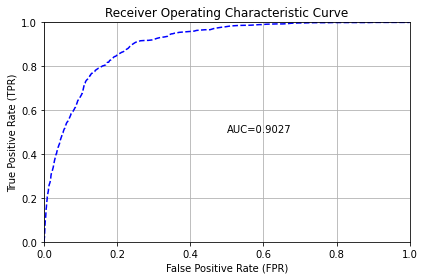

In [42]:
#Podemos obtener la curva ROC y AUC para los Datos de Testeo
performance_test.plot('roc')